# Graph for SBML network

Here we show a simple visualization of the SBML network.
Good python graph libraries are `networkX` and `igraph`. 

* [networkx](https://networkx.github.io/) http://networkx.github.io/documentation/latest/
* [igraph](http://igraph.org/redirect.html)

Create a simple graph of the SBML network for demonstration.

In [1]:
from __future__ import print_function, division
%matplotlib inline
import libsbml
import networkx as nx

In [2]:
# read demo model
from multiscale.examples import testdata
doc = libsbml.readSBMLFromFile(testdata.demo_sbml)
model = doc.getModel()
print(model)

<Model Koenig_demo_v09 "Koenig_demo_v09">


### Nodes and edges
In a first step the node and edge types for the graph are defined. The SBML species - reaction graph is a bipartite graph with possible edges between the species and reactions.

In [3]:
import json
from enum import IntEnum # use the IntEnum for JSON decodability
class NodeType(IntEnum):
    SPECIES = 0
    REACTION = 1
    

class EdgeType(IntEnum):
    REACTANT_REACTION = 0
    REACTION_PRODUCT = 1
    MODIFIER_REACTION = 2
    
json.dumps(NodeType.SPECIES)

'NodeType.SPECIES'

In [4]:
NodeType.SPECIES

<NodeType.SPECIES: 0>

In [31]:
import libsbml
import networkx as nx

def graph_from_sbml_model(model):
    g = nx.DiGraph()
    # add species nodes
    for s in model.species:
        g.add_node(s.id, name=s.name, compartment=s.compartment,
                      node_type=NodeType.SPECIES)
    # add reaction nodes
    for r in model.reactions:
        g.add_node(r.id, name=r.name, compartment=r.compartment,
                      node_type=NodeType.REACTION)
        # add the directed edges
        for reactant in r.reactants:
            g.add_edge(reactant.species, r.id, edge_type = EdgeType.REACTANT_REACTION)
        for product in r.products:
            g.add_edge(r.id, product.species, edge_type = EdgeType.REACTION_PRODUCT)
        for modifier in r.modifiers:
            g.add_edge(modifier.species, r.id, edge_type = EdgeType.MODIFIER_REACTION)
    return g

def graph_from_sbml_model_json(model):
    g = nx.DiGraph()
    # add species nodes
    for s in model.species:
        g.add_node(s.id, name=s.name, compartment=s.compartment,
                      node_type='species')
    # add reaction nodes
    for r in model.reactions:
        g.add_node(r.id, name=r.name, compartment=r.compartment,
                      node_type='reaction')
        # add the directed edges
        for reactant in r.reactants:
            g.add_edge(reactant.species, r.id, edge_type='reaction_reactant')
        for product in r.products:
            g.add_edge(r.id, product.species, edge_type='reaction_product')
        for modifier in r.modifiers:
            g.add_edge(modifier.species, r.id, edge_type='modifier_reaction')
    return g
    
g = graph_from_sbml_model(model)  
g1 = graph_from_sbml_model_json(model)  
print('nodes:', g.nodes())
print('edges:', g.edges())

nodes: ['v1', 'bA', 'bB', 'bC', 'e__A', 'e__C', 'e__B', 'v2', 'c__C', 'c__B', 'c__A', 'v3', 'v4']
edges: [('v1', 'c__B'), ('bA', 'c__A'), ('bB', 'e__B'), ('bC', 'e__C'), ('e__A', 'bA'), ('v2', 'c__C'), ('c__C', 'v3'), ('c__C', 'v4'), ('c__C', 'bC'), ('c__B', 'bB'), ('c__A', 'v1'), ('c__A', 'v2'), ('v3', 'c__A'), ('v4', 'c__B')]


<function node_colors at 0x7f5405b682a8>


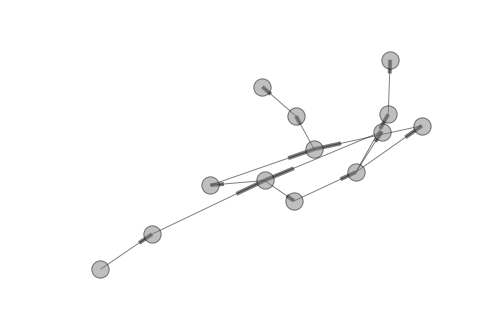

In [32]:
def node_colors():
    node_colors = []
    for n in g.nodes():
        if n.node_type == NodeType.SPECIES:
            node_colors.append('grey')
        elif n.node_type == NodeType.REACTION:
            node_colors.append('red')
        else:
            node_colors.append('black')
    return node_colors

print(node_colors)
nx.draw(g, node_color='grey', alpha=0.5)

## Load graph in Cytoscape
### Converting networkx -> JSON

Necessary to provide networks in JSON format for Cytoscape. The networkx network has to be converted to the used format.

In [33]:
import json

In [34]:
# Manually generates JSON as dictionary
empty_network = {
        'data': {
            'name': 'empty network'
        },
        'elements': {
            'nodes':[],
            'edges':[]
        }
}
# Uncomment this if you want to see the actual JSON object
print(json.dumps(empty_network, indent=4))

{
    "elements": {
        "nodes": [], 
        "edges": []
    }, 
    "data": {
        "name": "empty network"
    }
}


In [35]:
import copy

# Create a copy of the empty network object
small_network = copy.deepcopy(empty_network)

# Sequence of letters (a-z)
seq_letters = list(map(chr, range(ord('a'), ord('z')+1)))

# Build nodes and edges (in functional way)
build_node = lambda x: {'data': { 'id': x }}
abc_nodes = map(build_node, seq_letters)

build_edge = lambda x: {'data': { 'source': x, 'target': 'a' }}
rand_edges = map(build_edge, seq_letters)

small_network['elements']['nodes'] = abc_nodes
small_network['elements']['edges'] = rand_edges
small_network['data']['name'] = 'A is the hub.'

# Uncomment this if you want to see the actual JSON object
# print(json.dumps(small_network, indent=4))

In [37]:
import py2cytoscape
import py2cytoscape.util.util_networkx as util_networkx

# Convert NetworkX Graph object 
g_json = util_networkx.from_networkx(g)
g1_json = util_networkx.from_networkx(g1)
    
#print(json.dumps(g_json, indent=4))
# print(json.dumps(g1_json, indent=4))

## Using CyREST

Using REST (REpresentational State Transfer) communication between python and Cytoscapes.
A good REST introduction can be found at http://www.restapitutorial.com/lessons/whatisrest.html  
REST is resource based, these resources are identified by URIs. The resources are separate from their representation. Typical representations are JSON or XML, but could also be CSV based.

REST is stateless, the representation carries the state, must be cacheable.

Now start Cytoscape to make connection via the REST interface.

In [38]:
# HTTP Client for Python
import requests

# Standard JSON library
import json

# Basic Setup
PORT_NUMBER = 1234
BASE = 'http://localhost:' + str(PORT_NUMBER) + '/v1/'

# Header for posting data to the server as JSON
HEADERS = {'Content-Type': 'application/json'}

In [39]:
# Get server status
res = requests.get(BASE)
res

# some status information
def json_response(obj):
     return json.loads(obj.content);

def print_json(obj):
    obj_content = json_response(obj)
    print(json.dumps(obj_content, indent=4))    

print_json(res)

{
    "memoryStatus": {
        "usedMemory": 1490, 
        "freeMemory": 3221, 
        "maxMemory": 9762, 
        "totalMemory": 4712
    }, 
    "numberOfCores": 12, 
    "apiVersion": "v1"
}


In [40]:
# Start from a clean slate: remove all networks from current session
requests.delete(BASE + 'networks')

<Response [200]>

In [41]:
# send the network and create image
res1 = requests.post(BASE + 'networks', data=json.dumps(g1_json), headers=HEADERS)
print_json(res1)

{
    "networkSUID": 21906
}


In [42]:
res1_dict = json_response(res1)
suid = res1_dict['networkSUID']

# apply a layout
requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))

<Response [200]>

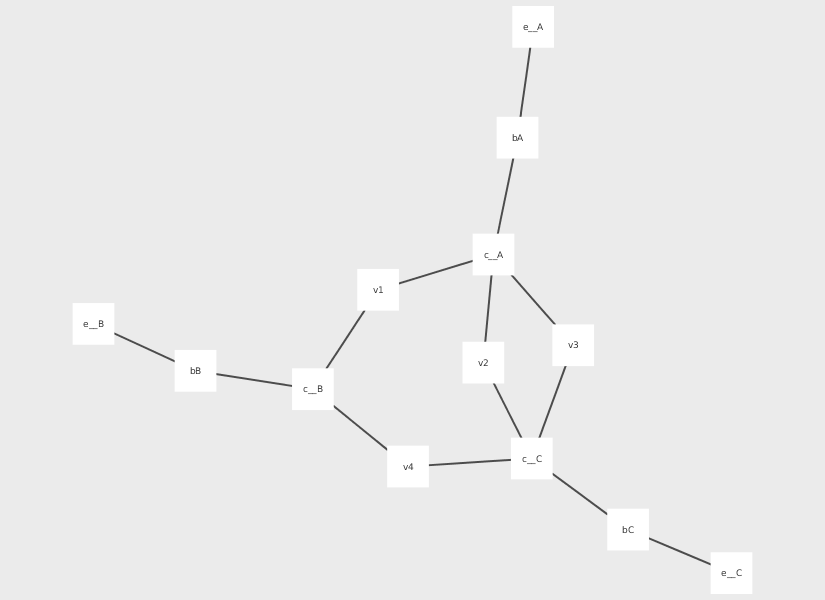

In [43]:
# create an image
from IPython.display import Image
Image(url=BASE+'networks/' + str(suid) + '/views/first.png', embed=True, width=600)

### Visual Styles

Define a custom visual style for the SBML network.

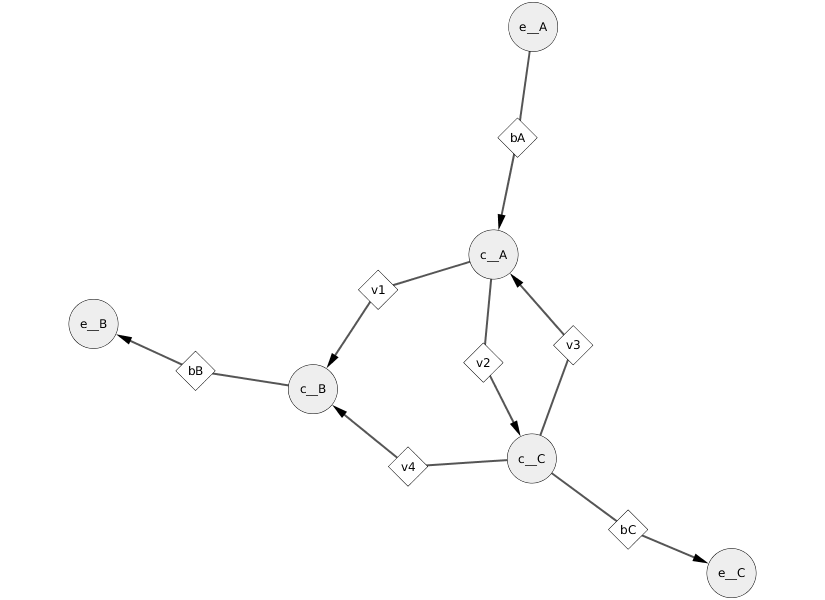

In [44]:
style_name = 'CYSBML'

my_style = {
  "title" : style_name,
  "defaults" : [ {
    "visualProperty" : "EDGE_WIDTH",
    "value" : 2.0
  }, {
    "visualProperty" : "EDGE_STROKE_UNSELECTED_PAINT",
    "value" : "#555555"
  }, {
    "visualProperty" : "NODE_FILL_COLOR",
    "value" : "#FFFFFF"
  },{
    "visualProperty" : "NODE_BORDER_WIDTH",
    "value" : 1
  }, {
    "visualProperty" : "NODE_SIZE",
    "value" : 50
  }],
  "mappings" : [ {
    "mappingType" : "discrete",
    "mappingColumn" : "node_type",
    "mappingColumnType" : "String",
    "visualProperty" : "NODE_FILL_COLOR",
    "map" : [ {
      "key" : "species",
      "value" : "#eeeeee"
    }, {
      "key" : "reaction",
      "value" : "#FFFFFF"
    } ]
  }, {
    "mappingType" : "discrete",
    "mappingColumn" : "node_type",
    "mappingColumnType" : "String",
    "visualProperty" : "NODE_SHAPE",
    "map" : [ {
      "key" : "species",
      "value" : "ELLIPSE"
    }, {
      "key" : "reaction",
      "value" : "DIAMOND"
    } ]
  }, {
    "mappingType" : "passthrough",
    "mappingColumn" : "name",
    "mappingColumnType" : "String",
    "visualProperty" : "NODE_LABEL"
  }, {
    "mappingType" : "discrete",
    "mappingColumn" : "node_type",
    "mappingColumnType" : "String",
    "visualProperty" : "NODE_SIZE",
    "map" : [ {
      "key" : "species",
      "value" : "50"
    }, {
      "key" : "reaction",
      "value" : "40"
    } ]
  }, {
    "mappingType" : "discrete",
    "mappingColumn" : "edge_type",
    "mappingColumnType" : "String",
    "visualProperty" : "EDGE_TARGET_ARROW_SHAPE",
    "map" : [ {
      "key" : "reaction_product",
      "value" : "DELTA"
    }, {
      "key" : "reaction_reactant",
      "value" : "NONE"
    } ]
  },
                
    ]
}

# Delete all style
requests.delete(BASE + "styles")

# Create new Visual Style
requests.post(BASE + "styles", data=json.dumps(my_style), headers=HEADERS)

# Apply it to current netwrok
requests.get(BASE + 'apply/styles/' + style_name + '/' + str(suid))

# Display it here!
Image(url=BASE+'networks/' + str(suid) + '/views/first.png', embed=True, width=500)

## Using CyRest js for the visualization

Although cyREST can create PNG image stream from network view, you may want to see networks as interactive visualizations in some situations.  By using py2cytoscape, you can visualize your networks in simple embedded Cytoscape.js widgets.

### System Requirments
* [Java 7+](http://www.oracle.com/technetwork/java/javase/downloads/jdk7-downloads-1880260.html)
* [Cytoscape 3.1.1 or later](http://cytoscape.org/download.html)
* [py2cytoscape](https://pypi.python.org/pypi/py2cytoscape)


In [49]:
from IPython.html.widgets import interact
from IPython.html.widgets import *
from IPython.html import widgets
# from notebook.widgets import 

# Package to render networks in Cytoscape.js
from py2cytoscape import cytoscapejs as cyjs
import json

In [57]:
networks = {}
# Layouts
layouts = cyjs.get_layouts()
print('layouts:', sorted(layouts.iterkeys()))

layouts: ['Breadthfirst', 'Circle', 'Concentric', 'Grid', 'Preset', 'Spring']


In [60]:
cyjs.render(network=g1_json, layout_algorithm=layouts['Spring'])
# render_graph(Network=g1_json, Style=my_style, Layout=layouts['Spring'])

<!DOCTYPE html>
 
 
 
 

 
 

 
 
 <!-- When only #uuid div is placed on this page,
 the height of output-box on ipynb will be 0px.
 One line below will prevent that. -->